<hr style="color:green" />
<h1 style="color:green">COSC2673 Assignment 2: Image Classification for Cancerous Cells</h1>
<h2 style="color:green">File 06: Basic PyTorch Fully Connected Neural Network model test on Main data</h2>
<hr style="color:green" />

<p>
In this file, attempt to apply techniques to deal with overfitting on the Basic 01 (3 layer FC NN) model. Experiment with L2 Regularization, Dropout maybe early stopping
</p>

In [83]:
import pandas as pd
import numpy as np
import os
import cv2

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torch.utils.data
import torchvision.transforms as transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.io import read_image


Configure this script as to whether it runs on Google Colab, or locally

In [84]:
# When on Google Colab, running full training, change both to true. Locally, advised set both to false
isGoogleColab = False
useFullData = False

In [85]:
# In local, the base directory is the current directory
baseDirectory = "./"

if isGoogleColab:
    from google.colab import drive
    
    # If this is running on Google colab, assume the notebook runs in a "COSC2673" folder, which also contains the data files 
    # in a subfolder called "image_classification_data"
    drive.mount("/content/drive")
    !ls /content/drive/'My Drive'/COSC2673/

    # Import the directory so that custom python libraries can be imported
    import sys
    sys.path.append("/content/drive/MyDrive/COSC2673/")

    # Set the base directory to the Google Drive specific folder
    baseDirectory = "/content/drive/MyDrive/COSC2673/"

Import the custom python files that contain reusable code

In [86]:
import data_basic_utility as dbutil
import graphing_utility as graphutil
import statistics_utility as statsutil

import a2_utility as a2util
import pytorch_utility as ptutil
from pytorch_utility import CancerBinaryDataset
from pytorch_utility import CancerCellTypeDataset


# randomSeed = dbutil.get_random_seed()
randomSeed = 266305
print("Random Seed: " + str(randomSeed))

Random Seed: 266305


In [87]:
# this file should have previously been created in the root directory
dfImages = pd.read_csv(baseDirectory + "images_main.csv")

In [88]:
# Get The training Split and the Validation Split
dfImagesTrain = dfImages[dfImages["trainValTest"] == 0].reset_index()
dfImagesVal = dfImages[dfImages["trainValTest"] == 1].reset_index()
dfImagesTest = dfImages[dfImages["trainValTest"] == 2].reset_index()

print(dfImagesTrain.shape)
print(dfImagesVal.shape)
print(dfImagesTest.shape)

dfImagesTrain.head()

(7837, 5)
(1031, 5)
(1028, 5)


,index,ImageName,isCancerous,cellType,trainValTest
0,0,./Image_classification_data/patch_images\1.png,0,0,0
1,1,./Image_classification_data/patch_images\10.png,0,0,0
2,3,./Image_classification_data/patch_images\1000.png,1,2,0
3,4,./Image_classification_data/patch_images\10000...,0,1,0
4,5,./Image_classification_data/patch_images\10001...,0,1,0


Note: The definition of the Custom Datasets for both the isCancerous data and the Cell Type data are defined in the pytorch_utility.py file.

Also, rather than loading all the training images and calculating the mean and standard deviation values in here, that was run separately in file 05a.PyTorchGetMeanAndStd.ipynb

Here we can just define the values to use, which shouldn't change unless the data is reloaded and a new train/validation/test split is generated

In [89]:
train_mean, train_std = ptutil.getTrainMeanAndStdTensors()
print(train_mean)
print(train_std)

tensor([0.8035, 0.5909, 0.7640])
tensor([0.1246, 0.1947, 0.1714])


In [90]:
# Create a tranform operation that also normalizes the images according to the mean and standard deviations of the images
transform_normalize = transforms.Compose(
    [transforms.ToPILImage(),
    transforms.ToTensor(), 
    transforms.Normalize(train_mean, train_std)])


In [91]:
cancerous_training_data = None

# Create a custom Dataset for the training and validation data
if useFullData:
    cancerous_training_data = CancerBinaryDataset(isGoogleColab, dfImagesTrain, baseDirectory, transform=transform_normalize)
else:
    # For testing in a small dataset
    dfImagesTrainTest = dfImagesTrain.iloc[range(1000), :].reset_index()
    cancerous_training_data = CancerBinaryDataset(isGoogleColab, dfImagesTrainTest, baseDirectory, transform=transform_normalize, target_transform=None)

cancerous_validation_data = CancerBinaryDataset(isGoogleColab, dfImagesVal, baseDirectory, transform=transform_normalize, target_transform=None)
cancerous_test_data = CancerBinaryDataset(isGoogleColab, dfImagesTest, baseDirectory, transform=transform_normalize, target_transform=None)

# Create data loaders
cancerous_train_dataloader = DataLoader(cancerous_training_data, batch_size=32, shuffle=True, num_workers=2)
cancerous_val_dataloader = DataLoader(cancerous_validation_data, batch_size=32, shuffle=True, num_workers=2)
cancerous_test_dataloader = DataLoader(cancerous_test_data, batch_size=32, shuffle=True, num_workers=2)

# L2 Regularization and Dropout

Apply L2 Regularization and trin a model. Then Predict on both Training and Validation data to get the training error and validation error, and see if there is any affect to reduce variance and overfitting

Also, define a class here that implements dropout, so various experiments can be run 

In [92]:
# Create a class for the Neural Network
class PT_NN_IsCancerous(nn.Module):

    # In the constructor, initialize the layers to use
    def __init__(self):
        super(PT_NN_IsCancerous, self).__init__()
        self.fc1 = nn.Linear(27 * 27 * 3, 1458)
        self.fc2 = nn.Linear(1458, 729)
        self.fc3 = nn.Linear(729, 2)
        
        # Final output Activation Function
        self.sigmoid = nn.Sigmoid()

    # Create the forward function, which is used in training
    def forward(self, x):
        # process through each layer
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.sigmoid(self.fc3(x))

        # return the result
        return x

# Create a class for the Neural Network with dropouts
class PT_NN_IsCancerous_Dropout(nn.Module):

    # In the constructor, initialize the layers to use
    def __init__(self, dropout_prob):
        super(PT_NN_IsCancerous_Dropout, self).__init__()
        self.dropProb = dropout_prob

        # 2 Dropout operations on the first two layers, don't do any dropouts on the output layer
        self.classifier = nn.Sequential(
            nn.Dropout(p=self.dropProb),
            nn.Linear(27 * 27 * 3, 1458),
            nn.ReLU(inplace=True),
            nn.Dropout(p=self.dropProb),
            nn.Linear(1458, 729),
            nn.ReLU(inplace=True),                        
            nn.Linear(729, 2),           
        )

    # Create the forward function, which is used in training
    def forward(self, x):
        # Run the Sequential Classifier Layer
        return self.classifier(x)



Now train the Fully Connected Neural Network Model.

During training, we will use the following:
- Softmax Cross Entropy Loss as our Loss function. This is a good Loss function that basically converts scores for each class into probabilities
- The Adam Optimizer, which is a version of Gradient Descent
- Initially, just 10 epochs

In [93]:
def predictCancerousOnDataSetF1(net, setName, dataloader, printResult=True, printFullResults=False):
    correct, total = 0,  0
    predictions = []

    y_cancerous = []
    y_pred_cancerous = []

    # Looping through this dataloader essentially processes them in batches of 32 (or whatever the batchsize is configured in the data loader
    for i, data in enumerate(dataloader, 0):
        inputs, labels = data

        # This should convert the image tensors into vectors
        inputs = inputs.view(-1, 27 * 27 * 3)

        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        
        # Loop through the batch, build the lists of the raw label and prediction values
        for j in range(len(labels)):
            y_cancerous.append(labels[j].item())
            y_pred_cancerous.append(predicted[j].item())

        predictions.append(predicted)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    f1Score = f1_score(y_cancerous, y_pred_cancerous)

    if printFullResults:
        print(setName + ":")        
        print('Confusion matrix: \n')
        print(confusion_matrix(y_cancerous, y_pred_cancerous))
        print("\n- Accuracy Score: " + str(accuracy_score(y_cancerous, y_pred_cancerous)))
        print("- Precision Score: " + str(precision_score(y_cancerous, y_pred_cancerous)))
        print("- Recall Score: " + str(recall_score(y_cancerous, y_pred_cancerous)))
        print("- F1 Score: " + str(f1Score))
    elif printResult:
        print("- " + setName + " F1: " + str(f1Score))        

    return f1Score, y_cancerous, y_pred_cancerous

In [94]:
bestValF1 = -1
bestTrainingF1 = -1
#bestDropoutProb = -1
bestWD = -1

dropoutVals = [0.2, 0.3, 0.4, 0.5]
decays = [0.00005, 0.0001, 0.0002, 0.0003]

net = None

# for dropout_rate in dropoutVals:

for wd in decays:   
    learning_rate = 0.0001 
    epochsToUse = 25

    criterion = nn.CrossEntropyLoss()

    # Use this for L2 Regularization
    tune_net = PT_NN_IsCancerous()
    optimizer = optim.Adam(tune_net.parameters(), lr=learning_rate, weight_decay=wd)

    # Use this for dropouts
    #tune_net = PT_NN_IsCancerous_Dropout(dropout_rate)
    tune_net = PT_NN_IsCancerous()
    optimizer = optim.Adam(tune_net.parameters(), lr=learning_rate)

    # Set the Neural Network into training mode
    tune_net.train()

    for epoch in range(epochsToUse):
        print("   Starting Epoch " + str(epoch) + "...")
        for i, data in enumerate(cancerous_train_dataloader, 0):
            # Get the inputs
            inputs, labels = data

            # This should convert the image tensors into vectors
            inputs = inputs.view(-1, 27 * 27 * 3)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Perform Forward and Backward propagation then optimize the weights
            outputs = tune_net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Set the Neural Network into evaluation (test) mode, so we can evaluate both training and validation error
    tune_net.eval()        
    trainingF1, y_train_cancerous, y_train_pred_cancerous = predictCancerousOnDataSetF1(tune_net, "Training", cancerous_train_dataloader, False, False)
    validationF1, y_val_cancerous, y_val_pred_cancerous = predictCancerousOnDataSetF1(tune_net, "Validation", cancerous_val_dataloader, False, False)

    print("- Completed with Weight Decay:  " + str(wd))
    print("- Validation F1 was " + str(validationF1))
    print("- Training F1 was " + str(trainingF1))

    if validationF1 > bestValF1:
        bestTrainingF1 = trainingF1
        bestValF1 = validationF1
        bestValF1 = wd

        # save this as the best net to use
        net = tune_net
        

   Starting Epoch 0...
   Starting Epoch 1...
   Starting Epoch 2...
   Starting Epoch 3...
   Starting Epoch 4...
   Starting Epoch 5...
   Starting Epoch 6...
   Starting Epoch 7...
   Starting Epoch 8...
   Starting Epoch 9...
   Starting Epoch 10...
   Starting Epoch 11...
   Starting Epoch 12...
   Starting Epoch 13...
   Starting Epoch 14...
   Starting Epoch 15...
   Starting Epoch 16...
   Starting Epoch 17...
   Starting Epoch 18...
   Starting Epoch 19...
   Starting Epoch 20...
   Starting Epoch 21...
   Starting Epoch 22...
   Starting Epoch 23...
   Starting Epoch 24...
- Completed with Weight Decay:  5e-05
- Validation F1 was 0.8633204633204634
- Training F1 was 0.9801553062985332
   Starting Epoch 0...
   Starting Epoch 1...
   Starting Epoch 2...
   Starting Epoch 3...
   Starting Epoch 4...
   Starting Epoch 5...
   Starting Epoch 6...
   Starting Epoch 7...
   Starting Epoch 8...
   Starting Epoch 9...
   Starting Epoch 10...
   Starting Epoch 11...
   Starting Epoch 

In [95]:
print("IsCancerous Results Model:")
print("- Best Weight Decay:  " + str(bestWD))
print("- Best Validation F1 was " + str(bestValF1))
print("- Best Training F1 was " + str(bestTrainingF1))

IsCancerous Results Model:
- Best Weight Decay:  -1
- Best Validation F1 was 0.0003
- Best Training F1 was 0.9767040552200172


Training Time in Nelson's Local Environment on the full data takes a very long time, stopped after 100 minutes. This will need to be done in Colab.

First, Predict on the training data so that we can find the training error.

In [96]:
correct, total = 0,  0
predictions = []

# Set the Neural Network into evaluation (test) mode
net.eval()

step=0

y_train_cancerous = []
y_train_pred_cancerous = []

# Looping through this dataloader essentially processes them in batches of 32 (or whatever the batchsize is configured in the data loader
for i, data in enumerate(cancerous_train_dataloader, 0):
    inputs, labels = data

    # This should convert the image tensors into vectors
    inputs = inputs.view(-1, 27 * 27 * 3)

    outputs = net(inputs)
    _, predicted = torch.max(outputs.data, 1)
    
    # Loop through the batch, build the lists of the raw label and prediction values
    for j in range(len(labels)):
        y_train_cancerous.append(labels[j].item())
        y_train_pred_cancerous.append(predicted[j].item())

    predictions.append(predicted)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()


print("Evaluate the Training Predictions and Error: \n")

print('Confusion matrix: \n')
print(confusion_matrix(y_train_cancerous, y_train_pred_cancerous))

print("\n- Accuracy Score: " + str(accuracy_score(y_train_cancerous, y_train_pred_cancerous)))
print("- Precision Score: " + str(precision_score(y_train_cancerous, y_train_pred_cancerous)))
print("- Recall Score: " + str(recall_score(y_train_cancerous, y_train_pred_cancerous)))
print("- F1 Score: " + str(f1_score(y_train_cancerous, y_train_pred_cancerous)))

Evaluate the Training Predictions and Error: 

Confusion matrix: 

[[407  19]
 [  8 566]]

- Accuracy Score: 0.973
- Precision Score: 0.9675213675213675
- Recall Score: 0.9860627177700348
- F1 Score: 0.9767040552200172


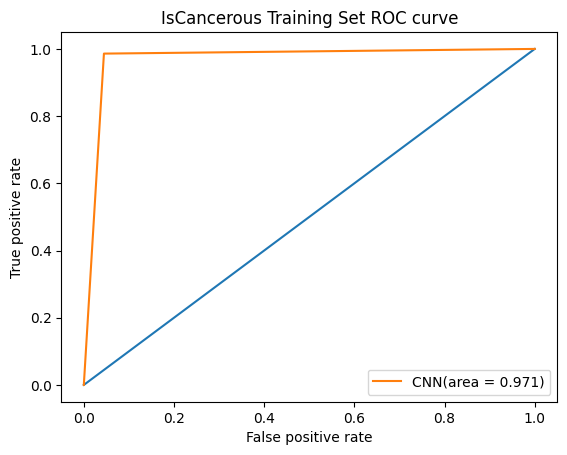

ROC (Area): 0.9707308894014494


0.9707308894014494

In [97]:
a2util.getClassificationROC("IsCancerous", "Training", y_train_cancerous, y_train_pred_cancerous)

Now Predict and evaluate on the test Set

In [98]:
correct, total = 0,  0
predictions = []

# Set the Neural Network into evaluation (test) mode
net.eval()

step=0

y_test_cancerous = []
y_test_pred_cancerous = []

# Looping through this dataloader essentially processes them in batches of 32 (or whatever the batchsize is configured in the data loader
for i, data in enumerate(cancerous_test_dataloader, 0):
    inputs, labels = data

    # This should convert the image tensors into vectors
    inputs = inputs.view(-1, 27 * 27 * 3)

    outputs = net(inputs)
    _, predicted = torch.max(outputs.data, 1)
    
    # Loop through the batch, build the lists of the raw label and prediction values
    for j in range(len(labels)):
        y_test_cancerous.append(labels[j].item())
        y_test_pred_cancerous.append(predicted[j].item())

    predictions.append(predicted)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()


print("Evaluate the Test Predictions and Error: \n")

print('Confusion matrix: \n')
print(confusion_matrix(y_test_cancerous, y_test_pred_cancerous))

print("\n- Accuracy Score: " + str(accuracy_score(y_test_cancerous, y_test_pred_cancerous)))
print("- Precision Score: " + str(precision_score(y_test_cancerous, y_test_pred_cancerous)))
print("- Recall Score: " + str(recall_score(y_test_cancerous, y_test_pred_cancerous)))
print("- F1 Score: " + str(f1_score(y_test_cancerous, y_test_pred_cancerous)))

Evaluate the Test Predictions and Error: 

Confusion matrix: 

[[293 112]
 [ 47 576]]

- Accuracy Score: 0.8453307392996109
- Precision Score: 0.8372093023255814
- Recall Score: 0.9245585874799358
- F1 Score: 0.8787185354691076


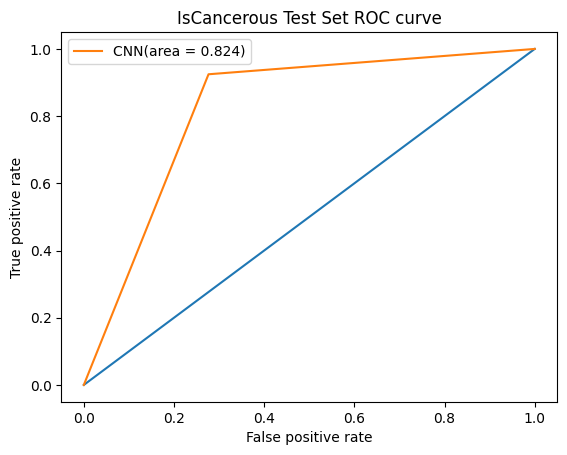

ROC (Area): 0.8240076888016963


0.8240076888016963

In [99]:
a2util.getClassificationROC("IsCancerous", "Test", y_test_cancerous, y_test_pred_cancerous, 2)

Now also train a model for CellType Predictions

In [100]:
celltype_training_data = None

# Create a custom Dataset for the training and validation data
if useFullData:
    celltype_training_data = CancerCellTypeDataset(isGoogleColab, dfImagesTrain, baseDirectory, transform=transform_normalize)
else:
    # For testing in a small dataset
    dfImagesTrainTest = dfImagesTrain.iloc[range(1000), :].reset_index()
    celltype_training_data = CancerCellTypeDataset(isGoogleColab, dfImagesTrainTest, baseDirectory, transform=transform_normalize, target_transform=None)

celltype_validation_data = CancerCellTypeDataset(isGoogleColab, dfImagesVal, baseDirectory, transform=transform_normalize)
celltype_test_data = CancerCellTypeDataset(isGoogleColab, dfImagesTest, baseDirectory, transform=transform_normalize)

# Create data loaders
celltype_train_dataloader = DataLoader(celltype_training_data, batch_size=32, shuffle=True, num_workers=2)
celltype_val_dataloader = DataLoader(celltype_validation_data, batch_size=32, shuffle=True, num_workers=2)
celltype_test_dataloader = DataLoader(celltype_test_data, batch_size=32, shuffle=True, num_workers=2)

Create a class for the Cell Type Neural Network model. The structure of the class will be fundamentally the same, only the model will need to output 4 classes

In [101]:
# Create a class for the Neural Network
class PT_NN_CellType(nn.Module):

    # In the constructor, initialize the layers to use
    def __init__(self):
        super(PT_NN_CellType, self).__init__()
        self.fc1 = nn.Linear(27 * 27 * 3, 1458)
        self.fc2 = nn.Linear(1458, 729)
        self.fc3 = nn.Linear(729, 4)
        
        # Final output Activation Function
        self.softmax = nn.Softmax(dim=1)

    # Create the forward function, which is used in training
    def forward(self, x):
        # process through each layer
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.softmax(self.fc3(x))

        # return the result
        return x


# Create a class for the Neural Network with dropouts
class PT_NN_CellType_Dropout(nn.Module):

    # In the constructor, initialize the layers to use
    def __init__(self, dropout_prob):
        super(PT_NN_CellType_Dropout, self).__init__()
        self.dropProb = dropout_prob

        # 2 Dropout operations on the first two layers, don't do any dropouts on the output layer
        self.classifier = nn.Sequential(
            nn.Dropout(p=self.dropProb),
            nn.Linear(27 * 27 * 3, 1458),
            nn.ReLU(inplace=True),
            nn.Dropout(p=self.dropProb),
            nn.Linear(1458, 729),
            nn.ReLU(inplace=True),                        
            nn.Linear(729, 4),    
            nn.Softmax(dim=1)       
        )

    # Create the forward function, which is used in training
    def forward(self, x):
        # Run the Sequential Classifier Layer
        return self.classifier(x)


Now train the Fully Connected Neural Network Model. Use the same configuration (objective function, optimizer etc) as the Binary Classifier

In [102]:
def predictCellTypeOnDataSetAccuracy(net, setName, dataloader, printResult=True, printFullResults=False):
    correct, total = 0,  0
    predictions = []

    y_celltype = []
    y_pred_celltype = []
    y_pred_celltype_scores = []

    # Looping through this dataloader essentially processes them in batches of 32 (or whatever the batchsize is configured in the data loader
    for i, data in enumerate(dataloader, 0):
        inputs, labels = data

        # This should convert the image tensors into vectors
        inputs = inputs.view(-1, 27 * 27 * 3)

        outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        
        # Loop through the batch, build the lists of the raw label and prediction values
        for j in range(len(labels)):
            y_celltype.append(labels[j].item())
            y_pred_celltype.append(predicted[j].item())
            y_pred_celltype_scores.append(outputs.data[j].tolist())

        predictions.append(predicted)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    accuracy = accuracy_score(y_celltype, y_pred_celltype)
    f1Score = f1_score(y_celltype, y_pred_celltype, average="micro")

    if printFullResults:
        print(setName + ":")        
        print('Confusion matrix: \n')
        print(confusion_matrix(y_celltype, y_pred_celltype))
        print("\n- Accuracy Score: " + str(accuracy))
        print("- Precision Score: " + str(precision_score(y_celltype, y_pred_celltype, average="micro")))
        print("- Recall Score: " + str(recall_score(y_celltype, y_pred_celltype, average="micro")))
        print("- F1 Score: " + str(f1Score))
    elif printResult:
        print("- " + setName + " F1: " + str(f1Score))

    return accuracy, y_celltype, y_pred_celltype, y_pred_celltype_scores

In [105]:
bestValAcc = -1
bestTrainingAcc = -1
#bestDropoutProb = -1
bestWD = -1

dropoutVals = [0.2, 0.3, 0.4, 0.5]
decays = [0.00005, 0.0001, 0.0002, 0.0003]

net = None

# for dropout_rate in dropoutVals:

for wd in decays:
    learning_rate = 0.0001
    epochsToUse = 25

    criterion = nn.CrossEntropyLoss()

    # Use this for L2 Regularization
    tune_net = PT_NN_CellType()
    optimizer = optim.Adam(tune_net.parameters(), lr=learning_rate, weight_decay=wd)

    # Use this for dropouts
    # tune_net = PT_NN_CellType_Dropout(dropout_rate)
    # optimizer = optim.Adam(tune_net.parameters(), lr=learning_rate)

    # Set the Neural Network into training mode
    tune_net.train()

    for epoch in range(epochsToUse):
        print("   Starting Epoch " + str(epoch) + "...")
        for i, data in enumerate(celltype_train_dataloader, 0):
            # Get the inputs
            inputs, labels = data

            # This should convert the image tensors into vectors
            inputs = inputs.view(-1, 27 * 27 * 3)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Perform Forward and Backward propagation then optimize the weights
            outputs = tune_net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

    # Set the Neural Network into evaluation (test) mode, so we can evaluate both training and validation error
    tune_net.eval()        
    trainingAcc, y_train_celltype, y_train_pred_celltype, y_train_pred_celltype_scores = predictCellTypeOnDataSetAccuracy(
        tune_net, "Training", celltype_train_dataloader, True, False)
    validationAcc, y_val_celltype, y_val_pred_celltype, y_val_pred_celltype_scores  = predictCellTypeOnDataSetAccuracy(
        tune_net, "Validation", celltype_val_dataloader, True, False)

    # print("- Completed with Dropout Prob:  " + str(dropout_rate))
    print("- Completed with Weight Decay Rate:  " + str(wd))
    print("- Validation Acc was " + str(validationAcc))
    print("- Training Acc was " + str(trainingAcc))

    if validationAcc > bestValAcc:
        bestTrainingAcc = trainingAcc
        bestValAcc = validationAcc
        bestWD = wd

        # save this as the best net to use
        net = tune_net
                    


   Starting Epoch 0...
   Starting Epoch 1...
   Starting Epoch 2...
   Starting Epoch 3...
   Starting Epoch 4...
   Starting Epoch 5...
   Starting Epoch 6...
   Starting Epoch 7...
   Starting Epoch 8...
   Starting Epoch 9...
   Starting Epoch 10...
   Starting Epoch 11...
   Starting Epoch 12...
   Starting Epoch 13...
   Starting Epoch 14...
   Starting Epoch 15...
   Starting Epoch 16...
   Starting Epoch 17...
   Starting Epoch 18...
   Starting Epoch 19...
   Starting Epoch 20...
   Starting Epoch 21...
   Starting Epoch 22...
   Starting Epoch 23...
   Starting Epoch 24...
- Training F1: 0.968
- Validation F1: 0.6983511154219205
- Completed with Weight Decay Rate:  5e-05
- Validation Acc was 0.6983511154219205
- Training Acc was 0.968
   Starting Epoch 0...
   Starting Epoch 1...
   Starting Epoch 2...
   Starting Epoch 3...
   Starting Epoch 4...
   Starting Epoch 5...
   Starting Epoch 6...
   Starting Epoch 7...
   Starting Epoch 8...
   Starting Epoch 9...
   Starting Epo

In [106]:
print("CellType Results Model:")
print("- Best Weight Decay:  " + str(bestWD))
print("- Best Validation F1 was " + str(bestValAcc))
print("- Best Training F1 was " + str(bestTrainingAcc))

CellType Results Model:
- Best Weight Decay:  5e-05
- Best Validation F1 was 0.6983511154219205
- Best Training F1 was 0.968


Predict on the Training Set to get the Training Accuracy and Error

In [107]:
correct, total = 0,  0
predictions = []

# Set the Neural Network into evaluation (test) mode
net.eval()

y_train_celltype = []
y_train_pred_celltype = []
y_train_pred_celltype_scores = []

showBatch=True

# Looping through this dataloader essentially processes them in batches of 32 (or whatever the batchsize is configured in the data loader
for i, data in enumerate(celltype_train_dataloader, 0):
    inputs, labels = data

    # This should convert the image tensors into vectors
    inputs = inputs.view(-1, 27 * 27 * 3)

    outputs = net(inputs)

    # outputs.data contains a tensor of size 4 for each record, with a score for each class. Use max
    # to select the class of the highest score for the prediction.
    class_score, predicted = torch.max(outputs.data, 1)
    
    # Loop through the batch, build the lists of the raw label and prediction values
    for j in range(len(labels)):
        y_train_celltype.append(labels[j].item())
        y_train_pred_celltype.append(predicted[j].item())
        y_train_pred_celltype_scores.append(outputs.data[j].tolist())

    showBatch = False
    
    predictions.append(predicted)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()


print("Evaluate the Training Predictions and Error: \n")

print('Confusion matrix: \n')
print(confusion_matrix(y_train_celltype, y_train_pred_celltype))

print("\n- Accuracy Score: " + str(accuracy_score(y_train_celltype, y_train_pred_celltype)))
print("- Precision Score: " + str(precision_score(y_train_celltype, y_train_pred_celltype, average="micro")))
print("- Recall Score: " + str(recall_score(y_train_celltype, y_train_pred_celltype, average="micro")))
print("- F1 Score: " + str(f1_score(y_train_celltype, y_train_pred_celltype, average="micro")))

Evaluate the Training Predictions and Error: 

Confusion matrix: 

[[114   1  11   0]
 [  0 131   6   1]
 [  1   1 572   0]
 [  0   0  11 151]]

- Accuracy Score: 0.968
- Precision Score: 0.968
- Recall Score: 0.968
- F1 Score: 0.968


In [108]:
for i in range(5):
    print(y_train_pred_celltype_scores[i])

[0.00033074661041609943, 0.9909945130348206, 0.008651363663375378, 2.344006315979641e-05]
[4.119914228795096e-05, 4.1437040465552855e-08, 0.9998927116394043, 6.608242983929813e-05]
[3.0726034310646355e-05, 4.34472795518559e-08, 0.9999692440032959, 8.441979060247462e-11]
[0.002272753044962883, 0.9951594471931458, 0.00017658057913649827, 0.0023912633769214153]
[0.0002507565950509161, 0.9995549321174622, 2.0047322323080152e-05, 0.00017431448213756084]


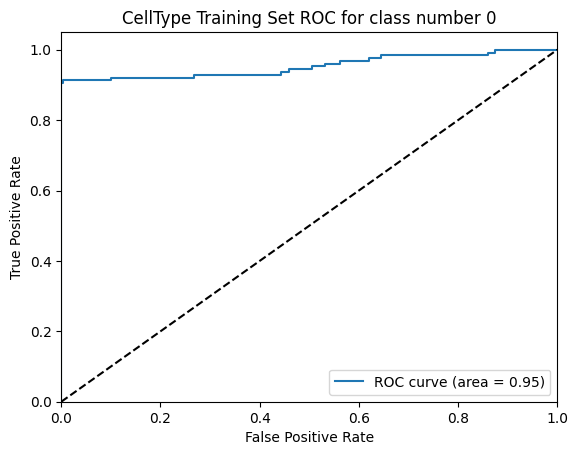

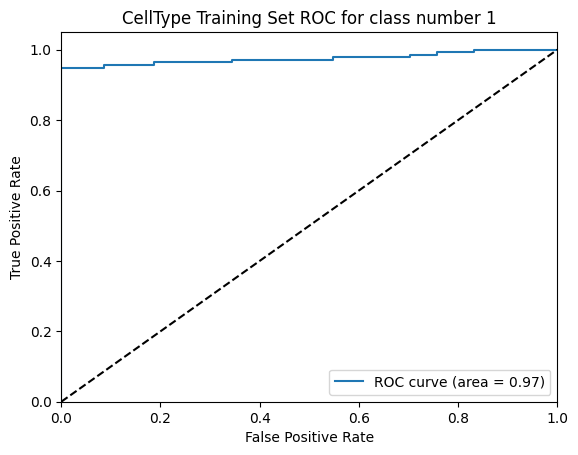

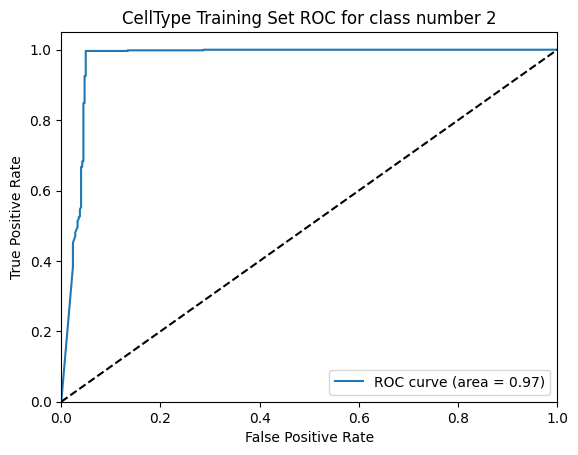

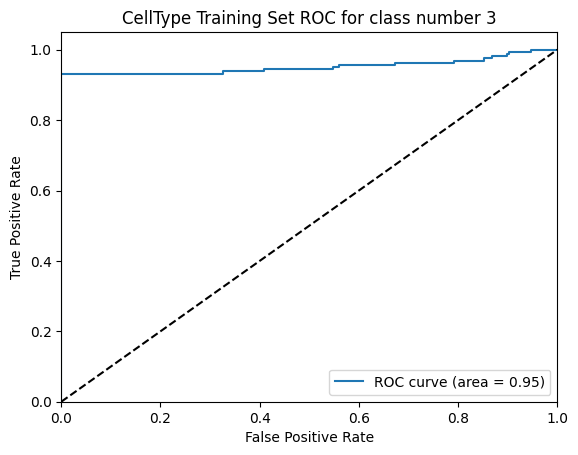

Mean ROC (Area): 0.9626269888348027


0.9626269888348027

In [109]:
a2util.getClassificationROC("CellType", "Training", y_train_celltype, y_train_pred_celltype, 4, y_train_pred_celltype_scores)

Now Predict and Evaluate on the Test Set

In [110]:
correct, total = 0,  0
predictions = []

# Set the Neural Network into evaluation (test) mode
net.eval()

y_test_celltype = []
y_test_pred_celltype = []
y_test_pred_celltype_scores = []

showBatch=True

# Looping through this dataloader essentially processes them in batches of 32 (or whatever the batchsize is configured in the data loader
for i, data in enumerate(celltype_test_dataloader, 0):
    inputs, labels = data

    # This should convert the image tensors into vectors
    inputs = inputs.view(-1, 27 * 27 * 3)

    outputs = net(inputs)

    # outputs.data contains a tensor of size 4 for each record, with a score for each class. Use max
    # to select the class of the highest score for the prediction.
    class_score, predicted = torch.max(outputs.data, 1)
    
    # Loop through the batch, build the lists of the raw label and prediction values
    for j in range(len(labels)):
        y_test_celltype.append(labels[j].item())
        y_test_pred_celltype.append(predicted[j].item())
        y_test_pred_celltype_scores.append(outputs.data[j].tolist())

    showBatch = False
    
    predictions.append(predicted)
    total += labels.size(0)
    correct += (predicted == labels).sum().item()


print("Evaluate the Test Predictions and Error: \n")

print('Confusion matrix: \n')
print(confusion_matrix(y_test_celltype, y_test_pred_celltype))

print("\n- Accuracy Score: " + str(accuracy_score(y_test_celltype, y_test_pred_celltype)))
print("- Precision Score: " + str(precision_score(y_test_celltype, y_test_pred_celltype, average="micro")))
print("- Recall Score: " + str(recall_score(y_test_celltype, y_test_pred_celltype, average="micro")))
print("- F1 Score: " + str(f1_score(y_test_celltype, y_test_pred_celltype, average="micro")))

Evaluate the Test Predictions and Error: 

Confusion matrix: 

[[ 43  22  47  28]
 [ 33  57  51  44]
 [ 12  13 589   9]
 [  8  15  44  13]]

- Accuracy Score: 0.6828793774319066
- Precision Score: 0.6828793774319066
- Recall Score: 0.6828793774319066
- F1 Score: 0.6828793774319066


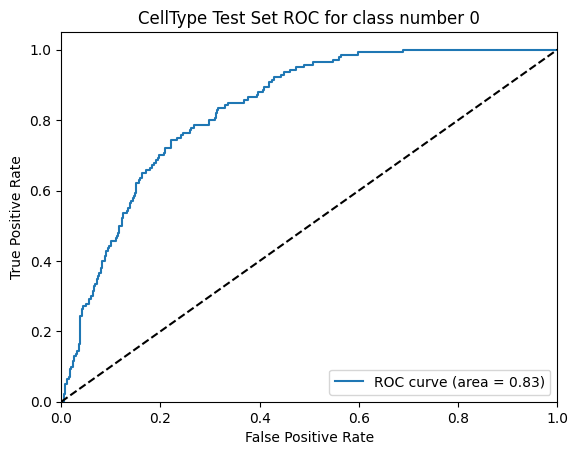

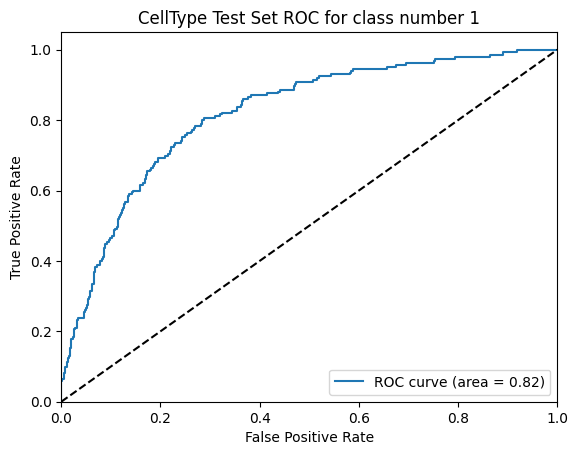

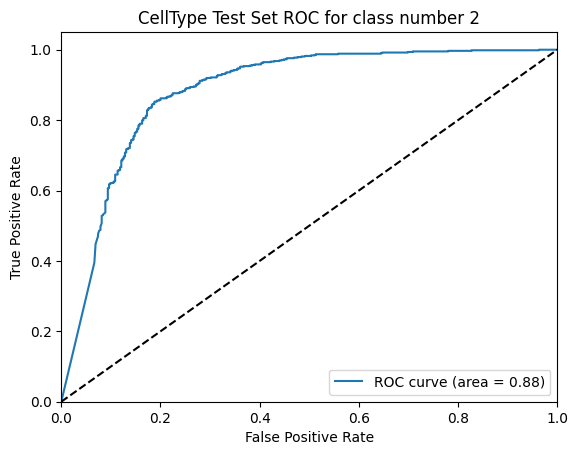

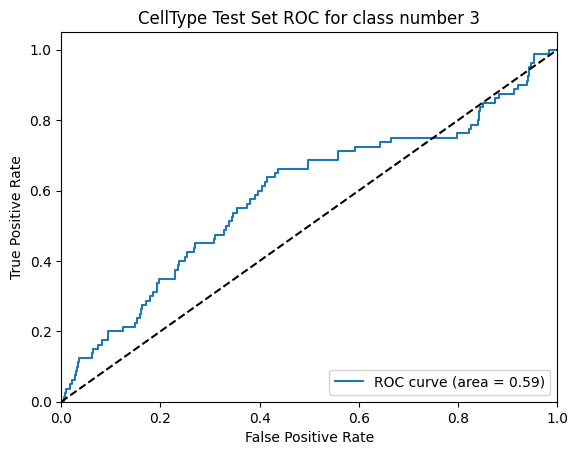

Mean ROC (Area): 0.7806704803347615


0.7806704803347615

In [111]:
a2util.getClassificationROC("CellType", "Test", y_test_celltype, y_test_pred_celltype, 4, y_test_pred_celltype_scores)

### IsCancerous Results

No L2 Reg or Dropout, 2 Layer NN (from file 05c) - On Colab, Full data
- Training Accuracy: 0.961
- Training F1 Score 0.945
- Test Accuracy: 0.873
- Test F1 Score: 0.894


L2 with weight_decay=0.0001:
- **Training**
- Accuracy Score: 0.9628684445578666
- Precision Score: 0.9581831290555155
- Recall Score: 0.9382280268266855
- F1 Score: 0.9481005885500268
- **Test**
- Accuracy Score: 0.8784046692607004
- Precision Score: 0.8977635782747604
- Recall Score: 0.9020866773675762
- F1 Score: 0.8999199359487591

L2 with weight_decay=0.001:
- Training Accuracy: 1
- Validation: 0.56
- Very bad

Dropout with rate 0.5
- **Training**
- Accuracy Score: 0.997
- Precision Score: 0.9948006932409013
- Recall Score: 1.0
- F1 Score: 0.9973935708079931
- **Validation**
- Accuracy Score: 0.8385214007782101
- Precision Score: 0.8100407055630936
- Recall Score: 0.9582664526484751
- F1 Score: 0.8779411764705881

Dropout with rate 0.25
- Training Accuracy: 1
- Validation: 0.82

### Cell Type Results

No L2 Reg or Dropout, 2 Layer NN (from file 05c) - On Colab, Full data
- Training Accuracy: 0.867
- Test Accuracy: 0.79


L2 with weight_decay=0.0001:
- **Training**
- Accuracy Score: 0.8302618816682832
- Precision Score: 0.8111111111111111
- Recall Score: 0.9373996789727127
- F1 Score: 0.8696947133283695
- **Validation**
- Accuracy Score: 0.7604267701260912
- Precision Score: 0.7604267701260912
- Recall Score: 0.7604267701260912
- F1 Score: 0.7604267701260912

L2 with weight_decay=0.001:
- Training Accuracy: 1
- Validation: 0.56
- Very bad

Dropout with rate 0.5
- **Training**
- Accuracy Score: 0.894
- Precision Score: 0.894
- Recall Score: 0.894
- F1 Score: 0.894
- **Test**
- Accuracy Score: 0.6750972762645915
- Precision Score: 0.6750972762645915
- Recall Score: 0.6750972762645915
- F1 Score: 0.6750972762645915


Dropout with rate 0.25
- Training Accuracy: 1
- Validation: 0.82

<h1>Analysis of Performance and Accuracy</h1>

<strong>Binary Classification - IsCancerous</strong>
<p>
In this model we see that the model has a very low training error and a high accuracy value, in this experiment achieving a 100% accuracy. This indicates that the model has <strong>low bias</strong>. However, when predicting on the validation dataset, the validation error rises. It can be seen that the Accuracy for the validation predictions is 84%, and the are under the ROC Curve is significantly less, with a value of 0.82. This is an indication of <strong>high variance</strong>, and in combination with low bias, indicates a possible problem of <strong>overfitting</strong>
</p>

<strong>Multi-class Classification - Cell Type</strong>
<p>
Similarly, the Cell Type model has a very low training error and a high accuracy value of 99.17%, indicating that the model has <strong>low bias</strong>. However, the Cell Type model has a considerably worse accuracy of only 72.94% when predicting on the validation dataset. A ROC curve is generated for each class, and it can be seen that the model performs better at predicting some classes compared to others. The average the under the ROC Curve score, with a value of 0.84. This indication of <strong>high variance</strong>, and in combination with low bias, indicates a possible problem of <strong>overfitting</strong>.
</p>


<strong>Next Steps</strong>
<p>
Before fully understanding this model configuration and exploring possible different models, first attempt to improve the performance of this model and fix any issues it might have
</p>
<p>
Common methods to deal with overfitting is to apply some form of regularization, such as Early Stopping or Dropout
</p>
<p>
Additionally, we can attempt to improve the accuracy in general with some methods such as adding additional layers and/or neurons per layer. However, this isn't too useful at this stage since the training accuracy is very high, indicating the complexity of the model at this stage is sufficient to capture enough complexity for good prediction.
</p>

